# Cell-Cycle Phase Classification from Bin–Bin Contact Counts

This notebook performs **EDA, feature engineering, and baseline ML classification** for a dataset with columns:
`Target_label, Cell_name, Chr_name, Bin_1, Bin_2, Count`.

**Targets:** one of `['G1', 'Early S', 'Middle S', 'Late S']`.

> **How to use**
> 1. Put your CSV path below (Section 1).
> 2. Run all cells.
> 3. Inspect EDA, generated features, and model performance.
>
> The notebook builds two modeling views:
> - **Row-level**: each `(Chr_name, Bin_1, Bin_2)` contact is an instance.
> - **Cell-level aggregated**: features are aggregated per `Cell_name` (reduces leakage and may better match label granularity).


### Imports

In [25]:
# === Imports ===
import os, time
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier




pd.set_option("display.max_columns",None)

## 1) Parameters

In [2]:
# === Parameters ===
# Provide your input CSV path here:
CSV_PATH = 'Nagano_Aggregated.csv'  # <-- CHANGE THIS to your file path

# Optional: sampling (set to None to use all rows)
ROW_SAMPLE_N = None  # e.g., 1_000_000 for speed during dev

# Memory guardrails for spectral/matrix features
MAX_BINS_PER_CHR_FOR_SPECTRAL = 2000   # build matrix only if unique bins per chr <= this
MAX_CONTACTS_PER_CHR_FOR_SPECTRAL = 400000  # skip spectral if too many edges
RANDOM_STATE = 42
N_JOBS = -1  # used where supported


## 2) Load Data & Basic Validation

In [3]:
# === Load ===
df = pd.read_csv(CSV_PATH)

In [4]:
df.head()

,Target_label,Cell_name,Chr_name,Bin_1,Bin_2,Count
0,late_S,late_S_273,chr1,95,95,72
1,late_S,late_S_273,chr1,14,14,42
2,late_S,late_S_273,chr1,45,84,2
3,late_S,late_S_273,chr1,52,53,6
4,late_S,late_S_273,chr1,159,159,53


In [5]:
expected_cols = {'Target_label','Cell_name','Chr_name','Bin_1','Bin_2','Count'}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

if ROW_SAMPLE_N is not None and len(df) > ROW_SAMPLE_N:
    df = df.sample(ROW_SAMPLE_N, random_state=RANDOM_STATE)

In [6]:
# Basic types
df['Bin_1'] = pd.to_numeric(df['Bin_1'], errors='coerce')
df['Bin_2'] = pd.to_numeric(df['Bin_2'], errors='coerce')
df['Count'] = pd.to_numeric(df['Count'], errors='coerce')

# Drop rows with NA in critical columns
print('Before Shape:', df.shape)
df = df.dropna(subset=['Target_label','Cell_name','Chr_name','Bin_1','Bin_2','Count'])
df = df.reset_index(drop=True)

print('After Shape:', df.shape)
df.head()

Before Shape: (20214896, 6)
After Shape: (20214896, 6)


,Target_label,Cell_name,Chr_name,Bin_1,Bin_2,Count
0,late_S,late_S_273,chr1,95,95,72
1,late_S,late_S_273,chr1,14,14,42
2,late_S,late_S_273,chr1,45,84,2
3,late_S,late_S_273,chr1,52,53,6
4,late_S,late_S_273,chr1,159,159,53


## 3) Exploratory Data Analysis (EDA)

In [7]:
# Class balance
label_counts = df['Target_label'].value_counts(normalize=True).sort_index()*100
print(label_counts)

Target_label
G1         29.679643
early_S    24.793850
late_S     26.155865
mid_S      19.370641
Name: proportion, dtype: float64


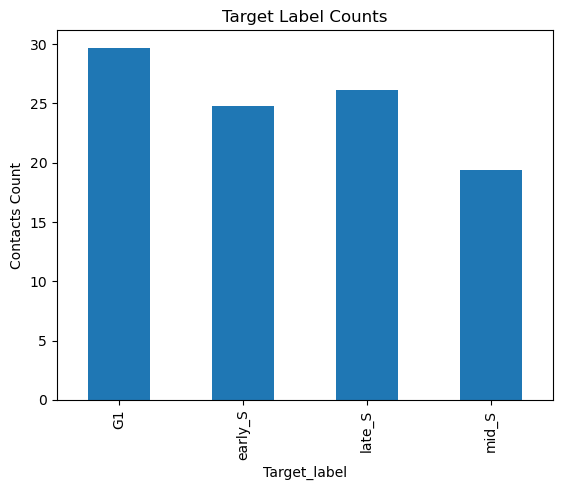

In [8]:
# Plot class balance
plt.figure()
label_counts.plot(kind='bar')
plt.title('Target Label Counts')
plt.xlabel('Target_label')
plt.ylabel('Contacts Count')
plt.show()

In [9]:
# Basic stats for numeric columns
display(df[['Bin_1','Bin_2','Count']].describe())

,Bin_1,Bin_2,Count
count,2.021490e+07,2.021490e+07,2.021490e+07
mean,6.606352e+01,8.083834e+01,1.606753e+01
std,4.127931e+01,4.211244e+01,3.452634e+01
min,0.000000e+00,3.000000e+00,1.000000e+00
25%,3.200000e+01,4.800000e+01,1.000000e+00
50%,6.200000e+01,7.900000e+01,3.000000e+00
75%,9.500000e+01,1.110000e+02,9.000000e+00
max,1.970000e+02,1.970000e+02,1.017000e+03


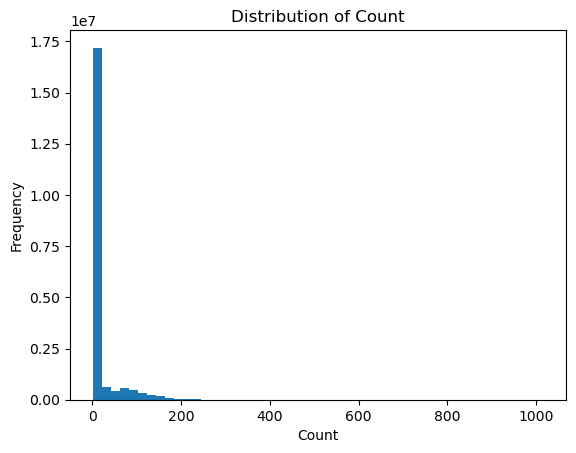

In [10]:
# Distribution of Count
plt.figure()
df['Count'].plot(kind='hist', bins=50)
plt.title('Distribution of Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

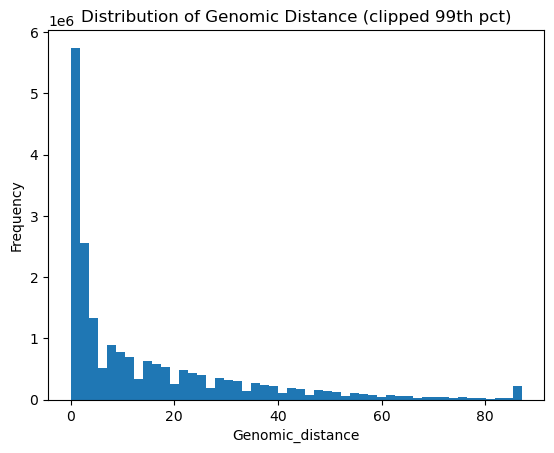

In [11]:
# Add genomic distance (absolute)
df['Genomic_distance'] = (df['Bin_2'] - df['Bin_1']).abs()
plt.figure()
df['Genomic_distance'].clip(upper=df['Genomic_distance'].quantile(0.99)).plot(kind='hist', bins=50)
plt.title('Distribution of Genomic Distance (clipped 99th pct)')
plt.xlabel('Genomic_distance')
plt.ylabel('Frequency')
plt.show()

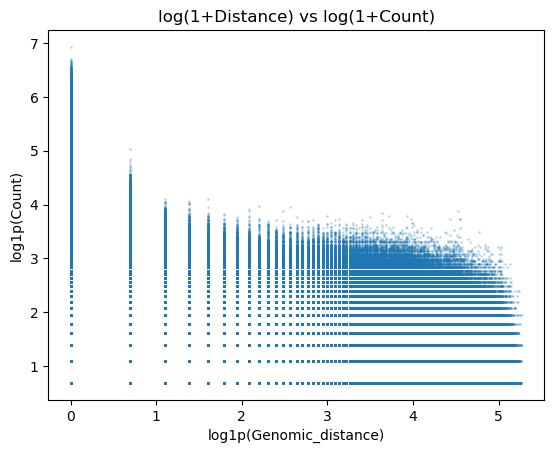

In [12]:
# Distance vs Count (log scales for readability)
plt.figure()
x = np.log1p(df['Genomic_distance'])
y = np.log1p(df['Count'])
plt.scatter(x, y, s=1, alpha=0.2)
plt.title('log(1+Distance) vs log(1+Count)')
plt.xlabel('log1p(Genomic_distance)')
plt.ylabel('log1p(Count)')
plt.show()

Chr_name
chr2    24285302
chr1    24200185
chr5    19231228
chr3    19033658
chr4    18997461
Name: Count, dtype: int64


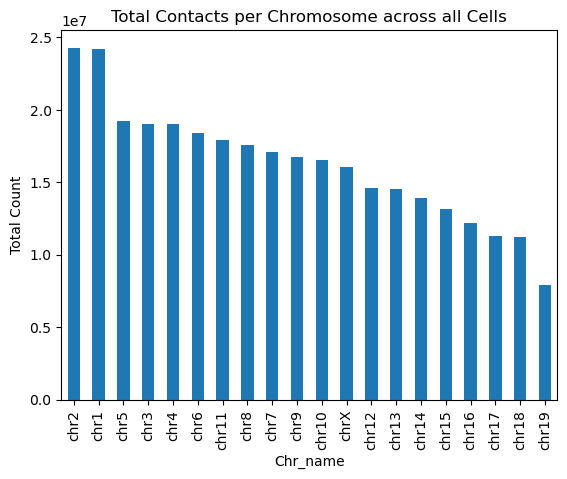

In [13]:
# Per-chromosome contact totals
chr_totals = df.groupby('Chr_name')['Count'].sum().sort_values(ascending=False)
print(chr_totals.head())
plt.figure()
chr_totals.plot(kind='bar')
plt.title('Total Contacts per Chromosome across all Cells')
plt.xlabel('Chr_name')
plt.ylabel('Total Count')
plt.show()

## 4) Feature Engineering (Row-Level)

In [14]:
def add_row_level_features(data: pd.DataFrame) -> pd.DataFrame:
    df2 = data.copy()

    # 1) Distance-based
    df2['Genomic_distance'] = (df2['Bin_2'] - df2['Bin_1']).abs()
    df2['Log_distance'] = np.log1p(df2['Genomic_distance'])

    # 2) Transformations of Count
    df2['Log_count'] = np.log1p(df2['Count'])

    # 3) Symmetry / order
    df2['Bin_min'] = df2[['Bin_1','Bin_2']].min(axis=1)
    df2['Bin_max'] = df2[['Bin_1','Bin_2']].max(axis=1)
    df2['Is_forward'] = (df2['Bin_1'] <= df2['Bin_2']).astype(int)
    df2['Midpoint'] = (df2['Bin_1'] + df2['Bin_2']) / 2.0

    # 4) Neighborhood / marginal features
    # Compute marginal sums per (Chr_name, Bin)
    # We'll do this efficiently by stacking
    tmp1 = df2[['Chr_name','Bin_1','Count']].rename(columns={'Bin_1':'Bin'})
    tmp2 = df2[['Chr_name','Bin_2','Count']].rename(columns={'Bin_2':'Bin'})
    # Counts #contacts for a bin with any other bin
    # Cell agnostic
    tmp = pd.concat([tmp1, tmp2], axis=0, ignore_index=True)
    bin_marginal = tmp.groupby(['Chr_name','Bin'])['Count'].sum().rename('Bin_total').reset_index()
    df2 = df2.merge(bin_marginal.rename(columns={'Bin':'Bin_1','Bin_total':'Bin1_total'}),
                    on=['Chr_name','Bin_1'], how='left')
    df2 = df2.merge(bin_marginal.rename(columns={'Bin':'Bin_2','Bin_total':'Bin2_total'}),
                    on=['Chr_name','Bin_2'], how='left')

    df2['Bin_total_min'] = df2[['Bin1_total','Bin2_total']].min(axis=1)
    df2['Bin_total_max'] = df2[['Bin1_total','Bin2_total']].max(axis=1)
    df2['Bin_total_sum'] = df2['Bin1_total'] + df2['Bin2_total']
    df2['Bin_total_diff_abs'] = (df2['Bin1_total'] - df2['Bin2_total']).abs()

    # 5) Observed/expected by distance (chromosome-specific)
    # Expected = mean Count at similar distance bucket within chromosome
    dist_bin = (df2['Genomic_distance'] / max(1, df2['Genomic_distance'].quantile(0.95)/50)).astype(int)
    df2['_dist_bin'] = dist_bin
    exp = df2.groupby(['Chr_name','_dist_bin'])['Count'].mean().rename('Expected_by_dist').reset_index()
    df2 = df2.merge(exp, on=['Chr_name','_dist_bin'], how='left')
    df2['Obs_over_exp_dist'] = df2['Count'] / (df2['Expected_by_dist'] + 1e-9)

    # 6) Percentile rank of Count within distance bin
    def pct_rank(group):
        return group.rank(pct=True)
    df2['Count_pct_in_dist_bin'] = df2.groupby(['Chr_name','_dist_bin'])['Count'].transform(pct_rank)

    # 7) Relative positions on chromosome (if you later add chr length, you can normalize)
    # For now, normalize by within-chr max bin seen in data
    chr_max_bin = pd.concat([
        df2.groupby('Chr_name')['Bin_1'].max(),
        df2.groupby('Chr_name')['Bin_2'].max()
    ], axis=1).max(axis=1).rename('Chr_max_bin')
    df2 = df2.merge(chr_max_bin, left_on='Chr_name', right_index=True, how='left')
    df2['Rel_pos_bin1'] = df2['Bin_1'] / (df2['Chr_max_bin'] + 1e-9)
    df2['Rel_pos_bin2'] = df2['Bin_2'] / (df2['Chr_max_bin'] + 1e-9)
    df2['Rel_pos_mid'] = df2['Midpoint'] / (df2['Chr_max_bin'] + 1e-9)

    # Clean up helper columns
    df2 = df2.drop(columns=['_dist_bin'], errors='ignore')

    return df2

df_feat = add_row_level_features(df)
print('Row-level features shape:', df_feat.shape)
df_feat.head()

Row-level features shape: (20214896, 26)


,Target_label,Cell_name,Chr_name,Bin_1,Bin_2,Count,Genomic_distance,Log_distance,Log_count,Bin_min,Bin_max,Is_forward,Midpoint,Bin1_total,Bin2_total,Bin_total_min,Bin_total_max,Bin_total_sum,Bin_total_diff_abs,Expected_by_dist,Obs_over_exp_dist,Count_pct_in_dist_bin,Chr_max_bin,Rel_pos_bin1,Rel_pos_bin2,Rel_pos_mid
0,late_S,late_S_273,chr1,95,95,72,0,0.000000,4.290459,95,95,1,95.0,279412,279412,279412,279412,558824,0,47.049672,1.530298,0.722324,197,0.482234,0.482234,0.482234
1,late_S,late_S_273,chr1,14,14,42,0,0.000000,3.761200,14,14,1,14.0,235870,235870,235870,235870,471740,0,47.049672,0.892674,0.589925,197,0.071066,0.071066,0.071066
2,late_S,late_S_273,chr1,45,84,2,39,3.688879,1.098612,45,84,1,64.5,215029,278594,215029,278594,493623,63565,2.601316,0.768842,0.537894,197,0.228426,0.426396,0.327411
3,late_S,late_S_273,chr1,52,53,6,1,0.693147,1.945910,52,53,1,52.5,271080,187824,187824,271080,458904,83256,47.049672,0.127525,0.173187,197,0.263959,0.269036,0.266497
4,late_S,late_S_273,chr1,159,159,53,0,0.000000,3.988984,159,159,1,159.0,285184,285184,285184,285184,570368,0,47.049672,1.126469,0.632196,197,0.807107,0.807107,0.807107


### Optional: Spectral / Matrix Features per Chromosome (Row-Level Merge)

In [16]:
# # We'll compute a simple leading eigenvalue proxy per chromosome contact matrix,
# # if (a) the number of unique bins is manageable and (b) number of contacts is below thresholds.
# # We then merge that as a per-row feature via the chromosome.

# def chromosome_spectral_feature(data: pd.DataFrame):
#     # returns DataFrame: Chr_name -> {'Chr_leading_eig': value, 'Chr_entropy': value}
#     results = []
#     for chr_name, sub in data.groupby('Chr_name'):
#         unique_bins = pd.Index(sorted(pd.unique(pd.concat([sub['Bin_1'], sub['Bin_2']]))))
#         nbins = len(unique_bins)
#         ncontacts = len(sub)

#         if nbins == 0 or nbins > MAX_BINS_PER_CHR_FOR_SPECTRAL or ncontacts > MAX_CONTACTS_PER_CHR_FOR_SPECTRAL:
#             # skip
#             continue

#         bin_to_idx = {b:i for i,b in enumerate(unique_bins)}
#         # Build sparse-ish matrix in dense form guarded by thresholds
#         M = np.zeros((nbins, nbins), dtype=float)
#         for _, r in sub.iterrows():
#             i = bin_to_idx[int(r['Bin_1'])]
#             j = bin_to_idx[int(r['Bin_2'])]
#             c = float(r['Count'])
#             M[i, j] += c
#             if i != j:
#                 M[j, i] += c  # symmetric

#         # Leading eigenvalue (power iteration)
#         v = np.random.rand(nbins)
#         v = v / (np.linalg.norm(v) + 1e-12)
#         for _ in range(50):
#             v = M @ v
#             norm = np.linalg.norm(v) + 1e-12
#             v = v / norm
#         leading_eig = float(v.T @ (M @ v))  # Rayleigh quotient

#         # Entropy of normalized weights
#         W = M.sum()
#         if W <= 0:
#             entropy = 0.0
#         else:
#             P = M.flatten() / W
#             P = P[P > 0]
#             entropy = float(-(P * np.log(P)).sum())

#         results.append({'Chr_name': chr_name,
#                         'Chr_leading_eig': leading_eig,
#                         'Chr_entropy': entropy})
#     return pd.DataFrame(results)

# chr_spec = chromosome_spectral_feature(df)
# if not chr_spec.empty:
#     df_feat = df_feat.merge(chr_spec, on='Chr_name', how='left')
# else:
#     df_feat['Chr_leading_eig'] = np.nan
#     df_feat['Chr_entropy'] = np.nan

# df_feat.head()

## 5) Baseline Model A: Row-Level Classification

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
%timeit
# Feature columns (exclude identifiers and raw bins if you like)
drop_cols = ['Target_label','Chr_name','Cell_name','Bin_1','Bin_2','Count'] # 'Chr_name','Cell_name',
X_cols = [c for c in df_feat.columns if c not in drop_cols]

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

X = df_feat[X_cols].copy()
# Encode the 'species' column
# X['Chr_name'] = label_encoder.fit_transform(X['Chr_name'])
# X['Cell_name'] = label_encoder.fit_transform(X['Cell_name'])
y = df_feat['Target_label'].copy()

X.head()

,Genomic_distance,Log_distance,Log_count,Bin_min,Bin_max,Is_forward,Midpoint,Bin1_total,Bin2_total,Bin_total_min,Bin_total_max,Bin_total_sum,Bin_total_diff_abs,Expected_by_dist,Obs_over_exp_dist,Count_pct_in_dist_bin,Chr_max_bin,Rel_pos_bin1,Rel_pos_bin2,Rel_pos_mid
0,0,0.000000,4.290459,95,95,1,95.0,279412,279412,279412,279412,558824,0,47.049672,1.530298,0.722324,197,0.482234,0.482234,0.482234
1,0,0.000000,3.761200,14,14,1,14.0,235870,235870,235870,235870,471740,0,47.049672,0.892674,0.589925,197,0.071066,0.071066,0.071066
2,39,3.688879,1.098612,45,84,1,64.5,215029,278594,215029,278594,493623,63565,2.601316,0.768842,0.537894,197,0.228426,0.426396,0.327411
3,1,0.693147,1.945910,52,53,1,52.5,271080,187824,187824,271080,458904,83256,47.049672,0.127525,0.173187,197,0.263959,0.269036,0.266497
4,0,0.000000,3.988984,159,159,1,159.0,285184,285184,285184,285184,570368,0,47.049672,1.126469,0.632196,197,0.807107,0.807107,0.807107


In [19]:
%timeit
# Numeric features only: (X is already numeric)
numeric_features = X.columns.tolist()

# Split stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Pipeline: scaler + logistic regression
pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, n_jobs=None if hasattr(LogisticRegression(), 'n_jobs') else None, multi_class='auto'))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('=== Version 1: Logistic Regression (Row-Level) ===')
print(classification_report(y_test, y_pred))

/home/kgulbarg/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Version 1: Logistic Regression (Row-Level) ===
              precision    recall  f1-score   support

          G1       0.33      0.65      0.44   1199942
     early_S       0.27      0.09      0.14   1002410
      late_S       0.30      0.39      0.34   1057477
       mid_S       0.35      0.00      0.00    783151

    accuracy                           0.32   4042980
   macro avg       0.31      0.28      0.23   4042980
weighted avg       0.31      0.32      0.25   4042980



In [ ]:
%timeit
# Random Forest as alternative
pipe_rf = Pipeline(steps=[
    ('clf', RandomForestClassifier(
        n_estimators=200, random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight='balanced_subsample'
    ))
])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print('=== Random Forest (Row-Level) ===')
print(classification_report(y_test, y_pred_rf))

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.72 μs


## Improvements

### Polynomial features

In [ ]:
%timeit

from sklearn.preprocessing import PolynomialFeatures

# Numeric features only: (X is already numeric)
numeric_features = X.columns.tolist()

# Split stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# Pipeline: scaler + logistic regression
pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', poly),
    ('clf', LogisticRegression(max_iter=200, n_jobs=None if hasattr(LogisticRegression(), 'n_jobs') else None, multi_class='auto'))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('=== Version 1: Logistic Regression (Row-Level) ===')
print(classification_report(y_test, y_pred)

In [ ]:
# Confusion matrix for RF
cm = confusion_matrix(y_test, y_pred_rf, labels=sorted(y.unique()))
print('Labels order:', sorted(y.unique()))
print(cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Row-Level RF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks(ticks=range(len(sorted(y.unique()))), labels=sorted(y.unique()), rotation=45)
plt.yticks(ticks=range(len(sorted(y.unique()))), labels=sorted(y.unique()))
plt.tight_layout()
plt.show()

## 6) Aggregation to Cell-Level Features

In [15]:
df_feat.head()

,Target_label,Cell_name,Chr_name,Bin_1,Bin_2,Count,Genomic_distance,Log_distance,Log_count,Bin_min,Bin_max,Is_forward,Midpoint,Bin1_total,Bin2_total,Bin_total_min,Bin_total_max,Bin_total_sum,Bin_total_diff_abs,Expected_by_dist,Obs_over_exp_dist,Count_pct_in_dist_bin,Chr_max_bin,Rel_pos_bin1,Rel_pos_bin2,Rel_pos_mid
0,late_S,late_S_273,chr1,95,95,72,0,0.000000,4.290459,95,95,1,95.0,279412,279412,279412,279412,558824,0,47.049672,1.530298,0.722324,197,0.482234,0.482234,0.482234
1,late_S,late_S_273,chr1,14,14,42,0,0.000000,3.761200,14,14,1,14.0,235870,235870,235870,235870,471740,0,47.049672,0.892674,0.589925,197,0.071066,0.071066,0.071066
2,late_S,late_S_273,chr1,45,84,2,39,3.688879,1.098612,45,84,1,64.5,215029,278594,215029,278594,493623,63565,2.601316,0.768842,0.537894,197,0.228426,0.426396,0.327411
3,late_S,late_S_273,chr1,52,53,6,1,0.693147,1.945910,52,53,1,52.5,271080,187824,187824,271080,458904,83256,47.049672,0.127525,0.173187,197,0.263959,0.269036,0.266497
4,late_S,late_S_273,chr1,159,159,53,0,0.000000,3.988984,159,159,1,159.0,285184,285184,285184,285184,570368,0,47.049672,1.126469,0.632196,197,0.807107,0.807107,0.807107


In [16]:
# We aggregate row-level engineered features to per-Cell_name features.
# This is often more aligned with the cell-cycle label being per-cell rather than per-contact.

def aggregate_cell_level(df_rowfeat: pd.DataFrame) -> pd.DataFrame:
    # Choose subset of numeric engineered features to aggregate
    feature_cols = [
        'Genomic_distance','Log_distance','Log_count',
        'Bin_total_min','Bin_total_max','Bin_total_sum','Bin_total_diff_abs',
        'Obs_over_exp_dist','Count_pct_in_dist_bin',
        'Rel_pos_bin1','Rel_pos_bin2','Rel_pos_mid',
        'Chr_leading_eig','Chr_entropy'
    ]
    feature_cols = [c for c in feature_cols if c in df_rowfeat.columns]

    # Aggregations
    agg_funcs = {
        'mean':'mean','std':'std','min':'min','max':'max','median':'median'
    }

    grp = df_rowfeat.groupby(['Cell_name','Target_label'])
    pieces = []
    for fname in feature_cols:
        piece = grp[fname].agg(['mean','std','min','max','median'])
        piece.columns = [f"{fname}_{k}" for k in piece.columns]
        pieces.append(piece)
    agg_df = pd.concat(pieces, axis=1)

    # Also add distance-based proportions (short/medium/long)
    tmp = df_rowfeat.copy()
    q1 = tmp['Genomic_distance'].quantile(0.33)
    q2 = tmp['Genomic_distance'].quantile(0.66)
    tmp['dist_bucket'] = np.where(tmp['Genomic_distance']<=q1, 'short',
                           np.where(tmp['Genomic_distance']<=q2, 'medium','long'))
    prop = tmp.pivot_table(index=['Cell_name','Target_label'],
                           columns='dist_bucket', values='Count',
                           aggfunc='sum', fill_value=0)
    prop = prop.div(prop.sum(axis=1)+1e-9, axis=0)
    prop.columns = [f"prop_{c}" for c in prop.columns]
    agg_df = agg_df.join(prop, how='left')

    agg_df = agg_df.reset_index()
    return agg_df

cell_df = aggregate_cell_level(df_feat)
print('Cell-level feature shape:', cell_df.shape)
cell_df.head()

Cell-level feature shape: (1171, 65)


,Cell_name,Target_label,Genomic_distance_mean,Genomic_distance_std,Genomic_distance_min,Genomic_distance_max,Genomic_distance_median,Log_distance_mean,Log_distance_std,Log_distance_min,Log_distance_max,Log_distance_median,Log_count_mean,Log_count_std,Log_count_min,Log_count_max,Log_count_median,Bin_total_min_mean,Bin_total_min_std,Bin_total_min_min,Bin_total_min_max,Bin_total_min_median,Bin_total_max_mean,Bin_total_max_std,Bin_total_max_min,Bin_total_max_max,Bin_total_max_median,Bin_total_sum_mean,Bin_total_sum_std,Bin_total_sum_min,Bin_total_sum_max,Bin_total_sum_median,Bin_total_diff_abs_mean,Bin_total_diff_abs_std,Bin_total_diff_abs_min,Bin_total_diff_abs_max,Bin_total_diff_abs_median,Obs_over_exp_dist_mean,Obs_over_exp_dist_std,Obs_over_exp_dist_min,Obs_over_exp_dist_max,Obs_over_exp_dist_median,Count_pct_in_dist_bin_mean,Count_pct_in_dist_bin_std,Count_pct_in_dist_bin_min,Count_pct_in_dist_bin_max,Count_pct_in_dist_bin_median,Rel_pos_bin1_mean,Rel_pos_bin1_std,Rel_pos_bin1_min,Rel_pos_bin1_max,Rel_pos_bin1_median,Rel_pos_bin2_mean,Rel_pos_bin2_std,Rel_pos_bin2_min,Rel_pos_bin2_max,Rel_pos_bin2_median,Rel_pos_mid_mean,Rel_pos_mid_std,Rel_pos_mid_min,Rel_pos_mid_max,Rel_pos_mid_median,prop_long,prop_medium,prop_short
0,G1_1,G1,13.573416,19.613125,0,152,3.0,1.733732,1.434151,0.0,5.030438,1.386294,1.447007,0.910755,0.693147,4.605170,1.098612,242084.917076,54971.445031,202,866408,242555.0,275830.012893,51198.188958,695,866408,278967.0,517914.929969,97894.553207,1390,1732816,521317.0,33745.095817,41266.028343,0,644563,21461.0,0.442431,0.339843,0.017152,3.651586,0.372153,0.321826,0.204430,0.013574,0.977653,0.226512,0.476313,0.270966,0.015228,1.0,0.465116,0.575340,0.271124,0.015228,1.0,0.590164,0.525826,0.261380,0.015228,1.0,0.527778,0.080471,0.064133,0.855396
1,G1_10,G1,14.334655,14.859562,0,138,10.0,2.153037,1.206297,0.0,4.934474,2.397895,1.571710,1.050115,0.693147,5.579730,1.098612,237703.988320,53912.039855,16,866408,237927.0,281042.945045,50360.343149,658,866408,284293.0,518746.933365,93799.776315,1316,1732816,520250.0,43338.956724,45683.108151,0,676341,31768.0,0.879588,0.724853,0.017152,6.729479,0.703813,0.477453,0.267246,0.013574,0.998679,0.504495,0.475761,0.261822,0.015228,1.0,0.475904,0.581675,0.265884,0.015228,1.0,0.593548,0.528718,0.257791,0.015228,1.0,0.538071,0.095503,0.096534,0.807964
2,G1_100,G1,14.258807,12.846144,0,119,12.0,2.240374,1.126506,0.0,4.787492,2.564949,1.432659,0.950612,0.693147,5.736572,1.098612,237269.247565,52762.832294,202,866408,237139.0,285076.002793,47915.722861,3271,866408,289395.0,522345.250358,89648.355457,6542,1732816,524342.0,47806.755228,46074.269412,0,676341,36528.0,0.811166,0.653210,0.017152,7.057525,0.674723,0.454343,0.260870,0.013574,0.999295,0.490453,0.472324,0.261037,0.015228,1.0,0.473684,0.579220,0.261960,0.015228,1.0,0.595420,0.525772,0.256526,0.015228,1.0,0.536184,0.125605,0.116094,0.758300
3,G1_101,G1,15.851466,15.682642,0,143,12.0,2.272627,1.190906,0.0,4.969813,2.564949,1.608215,1.080224,0.693147,5.988961,1.386294,235970.393580,53398.626857,237,866408,235944.0,281737.187189,48251.797399,658,866408,285542.0,517707.580770,91228.943290,1316,1732816,519277.5,45766.793609,45128.466751,0,674033,34591.5,1.030740,0.879690,0.017152,10.911307,0.737836,0.518441,0.280159,0.013574,0.999977,0.522870,0.467115,0.262684,0.015228,1.0,0.465409,0.583349,0.263072,0.015228,1.0,0.592000,0.525232,0.256384,0.015228,1.0,0.530612,0.101818,0.089761,0.808421
4,G1_102,G1,13.594406,20.913794,0,157,2.0,1.653106,1.468138,0.0,5.062595,1.098612,1.372676,0.835581,0.693147,4.343805,1.098612,243078.080682,55100.264399,646,866408,243314.0,277515.493970,51708.792684,6545,866408,280954.0,520593.574652,97900.114417,13090,1732816,522968.5,34437.413288,42839.752012,0,674033,21381.0,0.364093,0.282027,0.017152,3.217198,0.340168,0.275471,0.180393,0.013574,0.965783,0.215409,0.475513,0.271072,0.015228,1.0,0.464302,0.574079,0.272932,0.015228,1.0,0.600000,0.524796,0.261418,0.015228,1.0,0.530810,0.083050,0.059390,0.857561


## 7) Baseline Model B: Cell-Level Classification

### Define Train Test data sets

In [17]:
# Define Train Test Split
X_cell = cell_df.drop(columns=['Cell_name','Target_label'])
y_cell = cell_df['Target_label'].copy()

# Train/test split with stratification (note small N risk)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cell, y_cell, test_size=0.25, random_state=RANDOM_STATE, stratify=y_cell
)

### Logistic Regression

In [22]:
%timeit
pipe_cell = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False)),  # sparse-safe if needed
    ('clf', LogisticRegression(max_iter=500, multi_class='auto'))
])

pipe_cell.fit(Xc_train, yc_train)
yc_pred = pipe_cell.predict(Xc_test)
print('=== Version 2: Logistic Regression (Cell-Level) ===')
print(classification_report(yc_test, yc_pred))

=== Version 2: Logistic Regression (Cell-Level) ===
              precision    recall  f1-score   support

          G1       0.83      0.90      0.86        70
     early_S       0.75      0.86      0.80        76
      late_S       0.75      0.73      0.74        82
       mid_S       0.64      0.49      0.56        65

    accuracy                           0.75       293
   macro avg       0.74      0.74      0.74       293
weighted avg       0.74      0.75      0.74       293



/home/kgulbarg/.conda/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/kgulbarg/.conda/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Cell Classification

In [18]:
# Random Forest on cell-level
pipe_cell_rf = Pipeline(steps=[
    ('clf', RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=N_JOBS, class_weight='balanced_subsample'
    ))
])
pipe_cell_rf.fit(Xc_train, yc_train)
yc_pred_rf = pipe_cell_rf.predict(Xc_test)
print('=== Version 3: Random Forest (Cell-Level) ===')
print(classification_report(yc_test, yc_pred_rf))

=== Version 3: Random Forest (Cell-Level) ===
              precision    recall  f1-score   support

          G1       0.86      0.91      0.89        70
     early_S       0.71      0.84      0.77        76
      late_S       0.83      0.72      0.77        82
       mid_S       0.67      0.60      0.63        65

    accuracy                           0.77       293
   macro avg       0.77      0.77      0.77       293
weighted avg       0.77      0.77      0.77       293



In [20]:
# Random Forest Fetaure Importances on cell-level

# feature names (use DataFrame columns if available, else f0..fN)
if hasattr(Xc_train, "columns"):
    feat_names = Xc_train.columns.to_numpy()
else:
    feat_names = np.array([f"f{i}" for i in range(pipe_cell_rf.named_steps["clf"].n_features_in_)])

# importances from the RF inside the pipeline
importances = pipe_cell_rf.named_steps["clf"].feature_importances_

fi = (pd.DataFrame({"feature": feat_names, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True))

print(fi.head(20))

                      feature  importance
0                   prop_long    0.101902
1                  prop_short    0.076642
2                 prop_medium    0.052653
3           Bin_total_min_std    0.040539
4               Log_count_std    0.038183
5               Log_count_max    0.032234
6        Bin_total_sum_median    0.027836
7        Bin_total_min_median    0.027323
8              Log_count_mean    0.025675
9   Bin_total_diff_abs_median    0.023637
10           Log_distance_std    0.023553
11          Bin_total_sum_std    0.023510
12        Log_distance_median    0.022911
13           Rel_pos_bin2_std    0.021937
14           Rel_pos_bin1_std    0.021707
15         Bin_total_sum_mean    0.021341
16          Log_distance_mean    0.021329
17         Bin_total_min_mean    0.021014
18    Bin_total_diff_abs_mean    0.019493
19    Genomic_distance_median    0.018311


In [40]:
Top20 = fi['feature'][:20].tolist()
Top20

['prop_long',
 'prop_short',
 'prop_medium',
 'Bin_total_min_std',
 'Log_count_std',
 'Log_count_max',
 'Bin_total_sum_median',
 'Bin_total_min_median',
 'Log_count_mean',
 'Bin_total_diff_abs_median',
 'Log_distance_std',
 'Bin_total_sum_std',
 'Log_distance_median',
 'Rel_pos_bin2_std',
 'Rel_pos_bin1_std',
 'Bin_total_sum_mean',
 'Log_distance_mean',
 'Bin_total_min_mean',
 'Bin_total_diff_abs_mean',
 'Genomic_distance_median']

### XGB Cell Classification

In [27]:
%timeit

# 1) Encode labels
le = LabelEncoder()
yc_train_enc = le.fit_transform(yc_train)
yc_test_enc  = le.transform(yc_test)

# 2) (Optional) class imbalance → sample weights
w = compute_class_weight(class_weight='balanced',
                         classes=np.unique(yc_train_enc),
                         y=yc_train_enc)
class_weight = dict(zip(np.unique(yc_train_enc), w))
sample_weight = np.array([class_weight[c] for c in yc_train_enc])

# 3) XGBoost (trees don’t need scaling)
xgb = XGBClassifier(
    objective='multi:softprob',    # multiclass probabilities
    num_class=len(le.classes_),    # number of classes
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',            # faster on large data
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    eval_metric='mlogloss'
)

# 4) Fit (pass sample_weight if using it)
xgb.fit(Xc_train, yc_train_enc, sample_weight=sample_weight)

# 5) Predict and map back to original labels
yc_pred_enc = xgb.predict(Xc_test)
yc_pred = le.inverse_transform(yc_pred_enc)

print('=== Version 4: XGBoost (Cell-Level) ===')
print(classification_report(yc_test, yc_pred, target_names=le.classes_))


=== Version 4: XGBoost (Cell-Level) ===
              precision    recall  f1-score   support

          G1       0.90      0.91      0.91        70
     early_S       0.75      0.87      0.80        76
      late_S       0.86      0.68      0.76        82
       mid_S       0.67      0.71      0.69        65

    accuracy                           0.79       293
   macro avg       0.79      0.79      0.79       293
weighted avg       0.80      0.79      0.79       293



### LGBM Cell Classification

In [26]:
# 1) Encode labels (fit on train only)
le = LabelEncoder()
yc_train_enc = le.fit_transform(yc_train)
yc_test_enc  = le.transform(yc_test)

# 2) Optional: class imbalance → per-class weights
w = compute_class_weight(class_weight='balanced',
                         classes=np.unique(yc_train_enc),
                         y=yc_train_enc)
class_weight = {int(c): float(wt) for c, wt in zip(np.unique(yc_train_enc), w)}
# LightGBM accepts dict for multiclass (keys = class indices when y is encoded)

# 3) LGBM multiclass classifier
lgbm = LGBMClassifier(
    objective='multiclass',        # multiclass softmax
    num_class=len(le.classes_),    # K
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,                 # ~controls tree complexity
    max_depth=-1,                  # no hard cap; you can set 8–12 if overfitting
    min_child_samples=50,
    subsample=0.8,                 # row sampling
    colsample_bytree=0.8,          # feature sampling
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight=class_weight,     # or set to None to disable weighting
    metric='multi_logloss'
)

# 4) Fit (with early stopping if you like)
lgbm.fit(
    Xc_train, yc_train_enc,
    eval_set=[(Xc_test, yc_test_enc)],
    eval_metric='multi_logloss',
    callbacks=[]
    # for early stopping (LightGBM>=4): callbacks=[lgb.early_stopping(50, verbose=False)]
)

# 5) Predict and map back
yc_pred_enc = lgbm.predict(Xc_test)           # returns class indices
yc_pred = le.inverse_transform(yc_pred_enc)

print('=== Version 5: LightGBM (Cell-Level) ===')
print(classification_report(yc_test, yc_pred, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9878
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 50
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### LGBM with Top 20 features

In [53]:
Top20

['prop_long',
 'prop_short',
 'prop_medium',
 'Bin_total_min_std',
 'Log_count_std',
 'Log_count_max',
 'Bin_total_sum_median',
 'Bin_total_min_median',
 'Log_count_mean',
 'Bin_total_diff_abs_median',
 'Log_distance_std',
 'Bin_total_sum_std',
 'Log_distance_median',
 'Rel_pos_bin2_std',
 'Rel_pos_bin1_std',
 'Bin_total_sum_mean',
 'Log_distance_mean',
 'Bin_total_min_mean',
 'Bin_total_diff_abs_mean',
 'Genomic_distance_median']

In [54]:
# Define Train Test Split
X_cell = cell_df.drop(columns=['Cell_name','Target_label'])
X_cell = X_cell[Top20]
y_cell = cell_df['Target_label'].copy()

# Train/test split with stratification (note small N risk)
Xc_train_Topk, Xc_test_Topk, yc_train_Topk, yc_test_Topk = train_test_split(
    X_cell, y_cell, test_size=0.25, random_state=RANDOM_STATE, stratify=y_cell
)

In [55]:
# 1) Encode labels (fit on train only)
le = LabelEncoder()
yc_train_enc = le.fit_transform(yc_train_Topk)
yc_test_enc  = le.transform(yc_test_Topk)

# 2) Optional: class imbalance → per-class weights
w = compute_class_weight(class_weight='balanced',
                         classes=np.unique(yc_train_enc),
                         y=yc_train_enc)
class_weight = {int(c): float(wt) for c, wt in zip(np.unique(yc_train_enc), w)}
# LightGBM accepts dict for multiclass (keys = class indices when y is encoded)

# 3) LGBM multiclass classifier
lgbm = LGBMClassifier(
    objective='multiclass',        # multiclass softmax
    num_class=len(le.classes_),    # K
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,                 # ~controls tree complexity
    max_depth=-1,                  # no hard cap; you can set 8–12 if overfitting
    min_child_samples=50,
    subsample=0.8,                 # row sampling
    colsample_bytree=0.8,          # feature sampling
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight=class_weight,     # or set to None to disable weighting
    metric='multi_logloss'
)
# 4) Fit (with early stopping if you like)
lgbm.fit(
    Xc_train_Topk, yc_train_enc,
    eval_set=[(Xc_test_Topk, yc_test_enc)],
    eval_metric='multi_logloss',
    callbacks=[]
    # for early stopping (LightGBM>=4): callbacks=[lgb.early_stopping(50, verbose=False)]
)

# 5) Predict and map back
yc_pred_enc = lgbm.predict(Xc_test_Topk)           # returns class indices
yc_pred = le.inverse_transform(yc_pred_enc)

print('=== Version 6: LightGBM with only top features (Cell-Level) ===')
print(classification_report(yc_test, yc_pred, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4621
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 20
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

### LGBM after removing multicollinerity

In [56]:
correlation_matrix = X_cell.corr()

In [57]:
import seaborn as sns

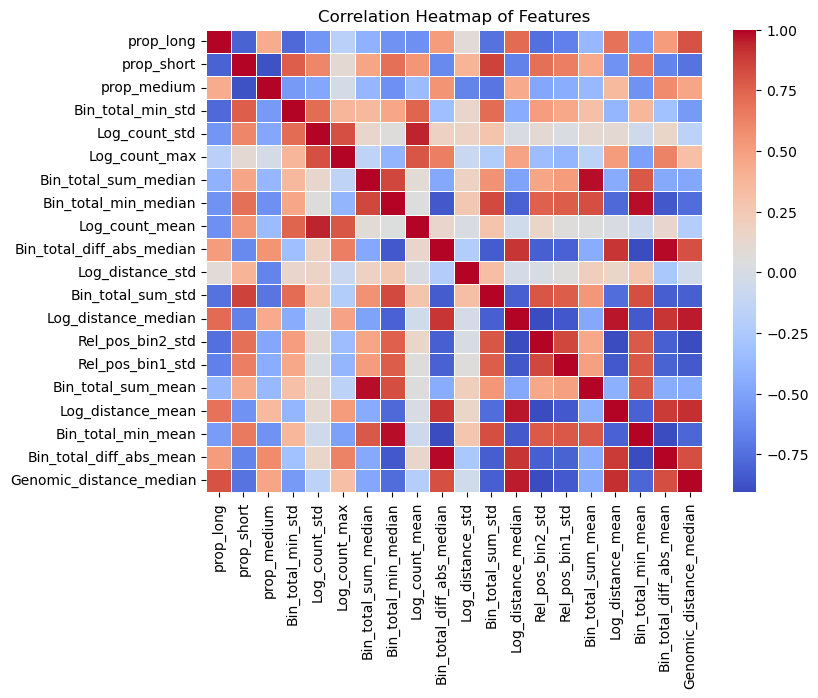

In [59]:
plt.figure(figsize=(8, 6)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()

In [60]:
correlation_matrix.columns

Index(['prop_long', 'prop_short', 'prop_medium', 'Bin_total_min_std',
       'Log_count_std', 'Log_count_max', 'Bin_total_sum_median',
       'Bin_total_min_median', 'Log_count_mean', 'Bin_total_diff_abs_median',
       'Log_distance_std', 'Bin_total_sum_std', 'Log_distance_median',
       'Rel_pos_bin2_std', 'Rel_pos_bin1_std', 'Bin_total_sum_mean',
       'Log_distance_mean', 'Bin_total_min_mean', 'Bin_total_diff_abs_mean',
       'Genomic_distance_median'],
      dtype='object')

In [65]:
# Define Train Test Split
X_cell = cell_df.drop(columns=['Cell_name','Target_label'])
X_cell = X_cell[Top20]
X_cell = X_cell.drop(columns=['prop_long','prop_short','Bin_total_min_median','Rel_pos_bin2_std'])
y_cell = cell_df['Target_label'].copy()

# Train/test split with stratification (note small N risk)
Xc_train_Topk, Xc_test_Topk, yc_train_Topk, yc_test_Topk = train_test_split(
    X_cell, y_cell, test_size=0.25, random_state=RANDOM_STATE, stratify=y_cell
)

In [66]:
# 1) Encode labels (fit on train only)
le = LabelEncoder()
yc_train_enc = le.fit_transform(yc_train_Topk)
yc_test_enc  = le.transform(yc_test_Topk)

# 2) Optional: class imbalance → per-class weights
w = compute_class_weight(class_weight='balanced',
                         classes=np.unique(yc_train_enc),
                         y=yc_train_enc)
class_weight = {int(c): float(wt) for c, wt in zip(np.unique(yc_train_enc), w)}
# LightGBM accepts dict for multiclass (keys = class indices when y is encoded)

# 3) LGBM multiclass classifier
lgbm = LGBMClassifier(
    objective='multiclass',        # multiclass softmax
    num_class=len(le.classes_),    # K
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,                 # ~controls tree complexity
    max_depth=-1,                  # no hard cap; you can set 8–12 if overfitting
    min_child_samples=50,
    subsample=0.8,                 # row sampling
    colsample_bytree=0.8,          # feature sampling
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    class_weight=class_weight,     # or set to None to disable weighting
    metric='multi_logloss'
)
# 4) Fit (with early stopping if you like)
lgbm.fit(
    Xc_train_Topk, yc_train_enc,
    eval_set=[(Xc_test_Topk, yc_test_enc)],
    eval_metric='multi_logloss',
    callbacks=[]
    # for early stopping (LightGBM>=4): callbacks=[lgb.early_stopping(50, verbose=False)]
)

# 5) Predict and map back
yc_pred_enc = lgbm.predict(Xc_test_Topk)           # returns class indices
yc_pred = le.inverse_transform(yc_pred_enc)

print('=== Version 7: LightGBM with only top features and minus multicollinearity (Cell-Level) ===')
print(classification_report(yc_test, yc_pred, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3604
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 16
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

### Evaluation using CV methods

In [72]:
# === Cross-validated evaluation for multiclass LGBM ===

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, balanced_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier

import lightgbm as lgb
# from lightgbm import early_stopping, log_evaluation  # (uncomment if using callbacks)

In [73]:


# ---- Inputs from your environment ----
# cell_df must exist with columns ['Cell_name','Target_label', ...features...]
# RANDOM_STATE, N_JOBS must also exist (or set them below)
RANDOM_STATE = 42
N_JOBS = -1

# ===== 1) Prepare X, y =====
X_cell = cell_df.drop(columns=['Cell_name', 'Target_label'])
y_cell = cell_df['Target_label'].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y_cell)
classes_ = np.unique(y_enc)
n_classes = len(classes_)

# ===== 2) Define the base LGBM model (no CV here; we’ll clone per fold) =====
base_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=n_classes,
    n_estimators=2000,          # large cap; early stopping will pick optimal
    learning_rate=0.03,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    metric='multi_logloss'
)

# ===== 3) CV config =====
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Storage for OOF predictions and fold metrics
oof_pred_enc = np.full_like(y_enc, fill_value=-1)
fold_metrics = []

print(f"\n=== LightGBM {n_splits}-Fold Stratified CV ===")
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_cell, y_enc), start=1):
    X_tr, X_va = X_cell.iloc[tr_idx], X_cell.iloc[va_idx]
    y_tr, y_va = y_enc[tr_idx], y_enc[va_idx]

    # Per-fold class weights (computed only on training fold)
    w = compute_class_weight(class_weight='balanced', classes=classes_, y=y_tr)
    cw = {int(c): float(wt) for c, wt in zip(classes_, w)}

    # Fresh model per fold (clone base_lgbm and set class_weight)
    lgbm = LGBMClassifier(**base_lgbm.get_params())
    lgbm.set_params(class_weight=cw)

    # Fit with early stopping on the validation fold
    # LightGBM>=4: use callbacks; older versions: use early_stopping_rounds
    lgbm.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(50, verbose=False)]
        # or: early_stopping_rounds=50
    )

    # Predict on validation fold
    y_va_pred = lgbm.predict(X_va)
    oof_pred_enc[va_idx] = y_va_pred

    # Fold metrics
    acc  = accuracy_score(y_va, y_va_pred)
    f1m  = f1_score(y_va, y_va_pred, average='macro')
    bacc = balanced_accuracy_score(y_va, y_va_pred)
    fold_metrics.append({'fold': fold, 'accuracy': acc, 'macro_f1': f1m, 'balanced_acc': bacc})

    print(f"Fold {fold}: acc={acc:.3f} | macroF1={f1m:.3f} | bAcc={bacc:.3f} | best_iter={lgbm.best_iteration_}")



=== LightGBM 5-Fold Stratified CV ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9912
[LightGBM] [Info] Number of data points in the train set: 936, number of used features: 52
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [74]:
# ===== 4) Aggregate OOF performance =====
fold_df = pd.DataFrame(fold_metrics)
print("\nPer-fold metrics:")
print(fold_df.round(3))

print("\nAggregate CV metrics (OOF):")
oof_acc  = accuracy_score(y_enc, oof_pred_enc)
oof_f1m  = f1_score(y_enc, oof_pred_enc, average='macro')
oof_bacc = balanced_accuracy_score(y_enc, oof_pred_enc)
print(f"OOF Accuracy     : {oof_acc:.3f}")
print(f"OOF Macro F1     : {oof_f1m:.3f}")
print(f"OOF Balanced Acc : {oof_bacc:.3f}")

# ===== 5) Detailed OOF report =====
oof_pred_labels = le.inverse_transform(oof_pred_enc)
report = classification_report(y_cell, oof_pred_labels, target_names=le.classes_)
print("\n=== OOF Classification Report (aggregated across folds) ===")
print(report)

# Confusion matrix (counts)
cm = confusion_matrix(y_cell, oof_pred_labels, labels=le.classes_)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in le.classes_], columns=[f"pred_{c}" for c in le.classes_])
print("\nConfusion Matrix (OOF counts):")
print(cm_df)

# Normalized confusion matrix (row-normalized)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cmn_df = pd.DataFrame(cm_norm, index=[f"true_{c}" for c in le.classes_], columns=[f"pred_{c}" for c in le.classes_])
print("\nConfusion Matrix (OOF row-normalized):")
print(cmn_df.round(3))


Per-fold metrics:
   fold  accuracy  macro_f1  balanced_acc
0     1     0.766     0.761         0.761
1     2     0.774     0.769         0.770
2     3     0.795     0.789         0.791
3     4     0.803     0.799         0.799
4     5     0.765     0.763         0.765

Aggregate CV metrics (OOF):
OOF Accuracy     : 0.781
OOF Macro F1     : 0.776
OOF Balanced Acc : 0.777

=== OOF Classification Report (aggregated across folds) ===
              precision    recall  f1-score   support

          G1       0.88      0.91      0.89       280
     early_S       0.78      0.82      0.80       303
      late_S       0.80      0.78      0.79       326
       mid_S       0.65      0.61      0.63       262

    accuracy                           0.78      1171
   macro avg       0.78      0.78      0.78      1171
weighted avg       0.78      0.78      0.78      1171


Confusion Matrix (OOF counts):
              pred_G1  pred_early_S  pred_late_S  pred_mid_S
true_G1           254            19 

## 8) Optional: Grouped Cross-Validation (Row-Level)

In [ ]:
# If multiple rows belong to the same Cell_name, leakage can happen in simple splits.
# Here we show GroupKFold to keep whole cells in folds.

groups = df_feat['Cell_name']
Xg = df_feat[X_cols]
yg = df_feat['Target_label']

gkf = GroupKFold(n_splits=5)
scores = []
for fold, (tr, te) in enumerate(gkf.split(Xg, yg, groups)):
    model = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=200))
    ])
    model.fit(Xg.iloc[tr], yg.iloc[tr])
    scores.append(model.score(Xg.iloc[te], yg.iloc[te]))
print('Grouped 5-fold CV accuracy (row-level, LR):', scores, 'mean=', np.mean(scores))

## 9) Save Engineered Datasets

In [ ]:
OUT_ROW = 'engineered_row_level.parquet'
OUT_CELL = 'engineered_cell_level.parquet'

df_feat.to_parquet(OUT_ROW, index=False)
cell_df.to_parquet(OUT_CELL, index=False)

print('Saved:', OUT_ROW, 'and', OUT_CELL)

## 10) Next Steps
- Tune thresholds for distance buckets using domain knowledge (e.g., absolute kb/Mb cutoffs).
- Consider adding external annotations (GC content, replication timing) if available.
- Try gradient boosting (XGBoost/LightGBM) and calibrated probabilities.
- Investigate feature importances and SHAP values for interpretability.
- Build per-chromosome models and ensemble at the cell level.


# Chromosome Informed



In [35]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import numpy as np

# 0) Features/labels
X_cell = cell_df.drop(columns=['Target_label'])
y_cell = cell_df['Target_label'].copy()

# 1) Grouped split to avoid per-cell leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_cell, y_cell, groups=X_cell['Cell_name']))
X_train, X_test = X_cell.iloc[train_idx], X_cell.iloc[test_idx]
y_train, y_test = y_cell.iloc[train_idx], y_cell.iloc[test_idx]

# 2) Columns
cat_cols = ['Cell_name']
num_cols = [c for c in X_cell.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

# 3) Encode y
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# 4) LightGBM (multiclass)
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS,
    metric='multi_logloss'
)

pipe = Pipeline([
    ('prep', preprocess),
    ('clf', lgbm)
])

# IMPORTANT: tell LGBM which transformed columns are categorical.
# After the ColumnTransformer, the order is: [cat cols ... then num cols]
# We have exactly one categorical: it's at transformed index 0.
pipe.fit(X_train, y_train_enc, clf__categorical_feature=[0])

pred_enc = pipe.predict(X_test)
pred = le.inverse_transform(pred_enc)
print(classification_report(y_test, pred, target_names=le.classes_))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9882
[LightGBM] [Info] Number of data points in the train set: 878, number of used features: 53
[LightGBM] [Info] Start training from score -1.425788
[LightGBM] [Info] Start training from score -1.335229
[LightGBM] [Info] Start training from score -1.335229
[LightGBM] [Info] Start training from score -1.454637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/home/kgulbarg/.conda/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
